In [6]:
import numpy as np
import ete3 as ete

In [146]:
%load_ext rpy2.ipython

In [1]:
def getarray(locifile, tree, split1=0, split2=0):
    """ parse the loci list and return a presence/absence matrix ordered by 
        the tips on the tree"""
    ## parse the loci file
    loci = open(locifile).read().split("\n//")[:-1]
    ## order (ladderize) the tree
    tree.ladderize()
    
    ## get tip names
    names = tree.get_leaf_names()
    if split1:
        snames = [i.split("_", 1)[0] for i in names]
    else:
        snames = names
    
    ## make empty matrix
    lxs = np.zeros((len(snames), len(loci)))
    
    ## fill the matrix
    for loc in xrange(len(loci)):
        for seq in loci[loc].split("\n"):
            if ">" in seq:
                if split2:
                    lxs[snames.index(seq.split()[0][1:].rsplit("_", 1)[0]), loc] += 1
                else:
                    lxs[snames.index(seq.split()[0][1:]), loc] += 1

    return lxs

In [2]:
def countmatrix(lxsabove, lxsbelow, max=0):
    """ fill a matrix with pairwise data sharing
        between each pair of samples. You could put
        in two different 'share' matrices to have
        different results above and below the diagonal.
        Can enter a max value to limit fill along diagonal.
        """
    share = np.zeros((lxsabove.shape[0], 
                      lxsbelow.shape[0]))
    ## fill above
    names = range(lxsabove.shape[0])
    for row in lxsabove:
        for samp1,samp2 in itertools.combinations(names,2):
            shared = lxsabove[samp1, lxsabove[samp2,]>0].sum()
            share[samp1,samp2] = shared
    ## fill below
    for row in lxsbelow:
        for samp2,samp1 in itertools.combinations(names,2):
            shared = lxsabove[samp1, lxsabove[samp2,]>0].sum()
            share[samp1,samp2] = shared
    ## fill diagonal
    if not max:
        for row in range(len(names)):
            share[row,row] = lxsabove[row,].sum()
    else:
        for row in range(len(names)):
            share[row,row] = max
    return share

In [3]:
def count_inf4(tree, matrix, node):
    """ count the number of loci with data spanning 
    a given node in the tree """
    
    ## get children of selected node
    a, b = node.get_children()
    
    ## get tip descendents of a and b
    tips_a = set(a.get_leaf_names())
    tips_b = set(b.get_leaf_names())
    
    ## get every other tip (outgroups)
    upone = node.up
    if upone.is_root():
        ch = upone.children
        sis = [i for i in ch if i != node][0]
        if sis.children:
            tips_c = sis.children[0].get_leaf_names()
            tips_d = sis.children[1].get_leaf_names()
        else:
            return 0
    else:
        upone = set(node.up.get_leaf_names())
        tips_c = upone - tips_a - tips_b
        tips_all = set(tree.get_leaf_names())
        tips_d = tips_all - tips_a - tips_b - tips_c
    
    ## get indices in matrix for leaf tips
    names = tree.get_leaf_names()
    index_a = [names.index(i) for i in tips_a]
    index_b = [names.index(i) for i in tips_b]
    index_c = [names.index(i) for i in tips_c]
    index_d = [names.index(i) for i in tips_d]
   
    ## how man loci are "informative"
    inf = 0
    for col in matrix.T:
        hits_a = sum([col[i] for i in index_a])
        hits_b = sum([col[i] for i in index_b])
        hits_c = sum([col[i] for i in index_c])
        hits_d = sum([col[i] for i in index_d])

        if all([hits_a, hits_b, hits_c, hits_d]):
                inf += 1 
    return inf    

In [ ]:
def count_hier(tree, node):
    ## get children of selected node
    a, b = node.get_children()
    
    ## get tip descendents of a and b
    tips_a = set(a.get_leaf_names())
    tips_b = set(b.get_leaf_names())
    
    ## get every other tip (outgroups)
    upone = node.up
    if upone.is_root():
        ch = upone.children
        sis = [i for i in ch if i != node][0]
        if sis.children:
            tips_c = sis.children[0].get_leaf_names()
            tips_d = sis.children[1].get_leaf_names()
        else:
            return 0
    else:
        upone = set(node.up.get_leaf_names())
        tips_c = upone - tips_a - tips_b
        tips_all = set(tree.get_leaf_names())
        tips_d = tips_all - tips_a - tips_b - tips_c
    
    ## get indices in matrix for leaf tips
    names = tree.get_leaf_names()
    index_a = [names.index(i) for i in tips_a]
    index_b = [names.index(i) for i in tips_b]
    index_c = [names.index(i) for i in tips_c]
    index_d = [names.index(i) for i in tips_d]
   
    ## avg. tips per quartet edge
    meanhier = np.median([len(i) for i in [index_a, index_b, index_c, index_d]])
    minhier = min([len(i) for i in [index_a, index_b, index_c, index_d]])
    
    return medianhier, minhier

In [167]:
def count_nest(tree, node):
    ## get children of selected node
    leaves_down = tree.get_leaf_names()
    ## get all other tips
    leaves_up = list(set(tree.get_leaf_names()) - set(leaves_down))

    ## get distances to leaves below (+1 because we aren't counting closest node)
    n1 = [node.get_distance(tree.get_leaves_by_name(name)[0], topology_only=True)+1 for name in leaves_down]
    n2 = [node.get_distance(tree.get_leaves_by_name(name)[0], topology_only=True) for name in leaves_up]
   
    return np.mean(n1+n2), np.min(n1+n2)

### Calculation

In [182]:
## Viburnum
loci_vib = "empirical_1/fullrun/outfiles/empirical_1_full_m4.loci"
tree_vib = ete.Tree("empirical_1/fullrun/RAxML_bestTree.empirical_1_fullrun")
lxs_vib = getarray(loci_vib, tree_vib)
lxs_vib

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [38]:
## Quercus
loci_que = "empirical_3/outfiles/empirical_3_m4.loci"
tree_que = ete.Tree("empirical_3/RAxML_bestTree.empirical_3")
lxs_que = getarray(loci_que, tree_que)
lxs_que

array([[ 1.,  1.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  0.,  1.,  1.],
       [ 1.,  0.,  1., ...,  1.,  1.,  1.]])

In [180]:
## Orestias
loci_ore = "empirical_4/outfiles/empirical_4.loci"
tree_ore = ete.Tree("empirical_4/RAxML_bestTree.empirical_4")
lxs_ore = getarray(loci_ore, tree_ore)
lxs_ore

array([[ 0.,  0.,  1., ...,  1.,  1.,  0.],
       [ 1.,  0.,  1., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [183]:
def get_data(tree, lxs):
    data = []
    for node in tree.traverse():
        if not (node.is_leaf() or node.is_root() or node.up.is_root()):
            ## get number of quartet loci at this split
            a = count_inf4(tree, lxs, node)
            ## get closest leaf at this split
            bmean, bmin = count_nest(tree, node)
            ## get hierarch. (min N descendants) at split
            cmedian, cmin = count_hier(tree, node)
            ## save
            data.append([a, bmean, bmin, cmedian, cmin])
            #print "{:<6} {:<.3f} {:<.1f} {:<.3f} {:<.1f}".format(a, bmean, bmin, cmedian, cmin)
    data = np.array(data)
    return data

In [195]:
## get Vib data
data_vib = get_data(tree_vib, lxs_vib)

## get Quercus data
data_que = get_data(tree_que, lxs_que)

## get Orestias data
data_ore = get_data(tree_ore, lxs_ore)


In [196]:
dat = np.array(data)
%R -i data_vib
%R -i data_que
%R -i data_ore


	Spearman's rank correlation rho

data:  data_vib[, 5] and data_vib[, 1]
S = 14952, p-value = 6.206e-08
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6234835 


	Spearman's rank correlation rho

data:  data_que[, 5] and data_que[, 1]
S = 1573.7, p-value = 4.976e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.711559 


	Spearman's rank correlation rho

data:  data_ore[, 5] and data_ore[, 1]
S = 5324.3, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8520608 



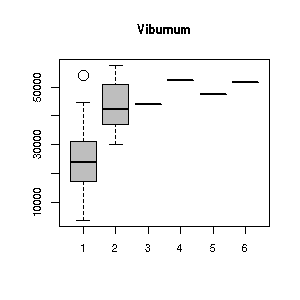

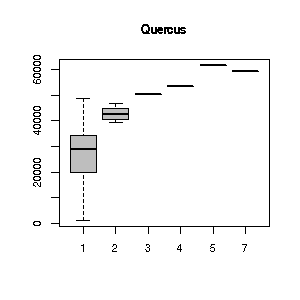

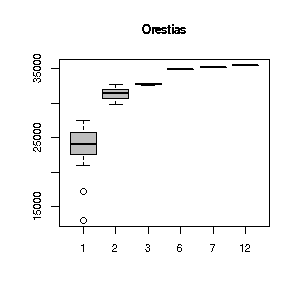

In [216]:
%%R -w 300 -h 300

#pdf("hierplots.pdf", width=4, height=12, pointsize=16)
#par(mfrow=c(3, 1))

boxplot(data_vib[,1] ~ data_vib[,5], col='gray', main="Viburnum", cex=2)
print(cor.test(data_vib[,5], data_vib[,1], method='s'))

boxplot(data_que[,1] ~ data_que[,5], col='gray', main="Quercus")
print(cor.test(data_que[,5], data_que[,1], method='s'))

boxplot(data_ore[,1] ~ data_ore[,5], col='gray', main="Orestias")
cor.test(data_ore[,5], data_ore[,1], method='s')

#dev.off()
